# EDA - MAFAT challenge

This notebook includes our EDA and conclusions regarding approaches for data augmentation and filtering later in the models.

Keynotes:

- **Imbalanced data**, for the training set - target tend towards the animal.
- **Imbalanced data**, SNR - the difference between high and low, and the number of images of target to each one of them
- **Geolocations** - different geolocations have a different distribution of the target.
- **Auxilary datasets** - each one of them has interesting data that we can use for data augmentation.
- Plotting spectrograms - we plotted spectrograms for:
  - animal vs human
  - HighSNR vs LowSNR
  - example of test spectogram and plots from the Auxilary datasets

we noticed that for us it's difficult to distinguish between animal and human or even different SNR types. this is still in the processwe hope that a nice CNN will be able to find the pattern that we are missing

# Vocabulary Update  
The project we decided to take focus on spectograms analysis. This very specific topic requires some terminology clarifications.

* __Doppler Radar__: The type of radar used to evaluate the limb motion of the animal of human.


---


* __Spectogram__: Way of visualisation of the radar spectrum output.

![picture](https://drive.google.com/uc?export=view&id=1j0-_Kp5azulBHvwibs7CZu29iWn-v3JA)



---



* __IQ data__: For now, a kind of blackbox composed of real and imaginary number. The spectograms we have to analyze are segments of 32 x 128 = Time x velocity. For each segment we have 32 * 128 = 4096 IQ values.
In simple words, it is the coordinates representation of the signal received by the radar



---



* __SNR__: Signal-to-noise ratio is a measure used in science and engineering that compares the level of a desired signal to the level of background noise.
> __low SNR__: More noise than desired signal  
> __High SNR__: More desired signal than noise

<img src="https://drive.google.com/uc?export=view&id=1NBj1yCwrZpvWNOtl-D1810206WnQT7LF" alt="drawing" width="800" height="400"/>



###**Data Description**   
The data contains I/Q signals of humans or animals collected by radar sensors in different locations and times.  
Each signal of human or animal is a single track. The tracks in the dataset are split into 32 time-units segments.   
Each record in the dataset represents a single segment.
The goal is to classify the segments correctly.   

A segment consists of a matrix with I/Q values and metadata. The matrix of each segment has a size of 32x128. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The Y-axis is usually referred to as “range” or “velocity” as wave propagation depends on the speed of light.

For example, for Pulse Repetition Interval (PRI) of 128 ms, each Y-axis is a bin of 1 ms. For pulse sent in t(n) and a signal received in t(n+m) where   
0 < m <=128 the signal is set in the “m” bin of pulse n.

* *Note: the numbers that are stated in the example above are not the real numbers and are given only for the sake of the example.*


####**Data Fields** 
8 fields describe each segment:

  

*   **segment_id** - The segment's unique ID. 
*   **target_type** - What is the object detected in the segment?   
The possible values are: "human", "animal", "empty".
*   **snr_type** - Signal to Noise Ratio (SNR), there are 3 categories:  
High SNR, Low SNR, and Synthetic Low SNR. The Synthetic segments are the   
High SNR signals in the dataset that transformed into Low SNR artificially,   
will be elaborated at the end of this notebook.   
The possible values are: "HighSNR", "LowSNR", "SynthSNR".   
*   **track_id** - Segment is part of a continuous track. Use this identifier to locate all segments of the same track.   
*   **geolocation_type** - Identifies the surrounding terrain type of each location (string, categorical).   
*   **geolocation_id** - Each location has a unique ID (integer).   
*   **sensor_id** - Each Radar has a unique ID (integer). In some of the locations were number of radars.   
*   **date_index** - Numerical, each number represents a unique   calendar day (integer).   

####**How the data was gathered** 
<img src="https://drive.google.com/uc?export=view&id=1Fi1ok6A898pn2iuguif_-r6Rz1qk_sSX" alt="drawing" width="600" height="400"/>

###**Setup**

In [16]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from termcolor import colored
from IPython.display import display

In [17]:
# Optional: mounting to Google Drive to read the data files.
from google.colab import drive
mount_path = '/content/gdrive'
drive.mount(mount_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [19]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


In [20]:
def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(mount_path, competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

In [21]:
training_path = 'MAFAT RADAR Challenge - Training Set V1'
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'

training_set = load_csv_metadata(training_path)
test_set = load_csv_metadata(test_path)

###**Training and Test sets Descriptives**

In [22]:
training_set.head() 

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type
0,0,11,C,1,1,HighSNR,27,animal
1,1,16,C,1,1,HighSNR,27,animal
2,2,16,C,1,1,HighSNR,27,animal
3,3,29,C,1,1,HighSNR,27,animal
4,4,29,C,1,1,HighSNR,27,animal


In [23]:
test_set.head()

,segment_id,snr_type
0,6656,HighSNR
1,6658,HighSNR
2,6662,LowSNR
3,6664,LowSNR
4,6665,LowSNR


In [24]:
# Number of obserevations (segments), and number of columns (fields)   
# except for the I/Q matrix and the doppler burst vector

print(f"The training set shape is: {training_set.shape}")
print(f"The test set shape is: {test_set.shape}")

The training set shape is: (6656, 8)
The test set shape is: (106, 2)


There are 6,656 signal segments in the training set (taken from 1,510 signal tracks),   
and 106 segments in the public test set.
   
The segments in the test set are selected in a way that guarantees a track has at most a single segment,   
with the exception of very long tracks that may contribute more than one segment.    
The segments in the test set and the training set are not from the same tracks.   
Also, in the training set, all the segments of the track are available as opposed to a single segment from each track in the test set.

In [25]:
# All fields in metadata are categorical, therefore only simple descriptives 
# like the mode and the number of unique values is relevant.
training_set = training_set.astype(str)
training_set.describe().iloc[1:]

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type
unique,6656,1510,3,4,4,2,29,2
top,5208,285,A,3,3,LowSNR,20,animal
freq,1,43,4811,4560,4560,4191,714,5757


In [26]:
test_set = test_set.astype(str)
test_set.describe().iloc[1:]

,segment_id,snr_type
unique,106,2
top,6683,HighSNR
freq,1,56


In [27]:
def check_missing(df):
  try:
    df.name =[x for x in globals() if globals()[x] is df][0]
    if sum(df.isnull().sum()) == 0:
      print(f"None of the columns in {df.name} have missing data.")
  except:
    print(df.isnull().any())

check_missing(test_set)
check_missing(training_set)

None of the columns in test_set have missing data.
None of the columns in training_set have missing data.


In [28]:
print(f"The number of tracks in the training set is: {training_set['track_id'].nunique()}")

The number of tracks in the training set is: 1510


There are 1,510 signal tracks split to 6,656 signal segments in the training set.  
We are asked to classify signal segments. Animals (0) or Humans (1)
The tracks and segments' SNR can be Low or High SNR.   
In some cases (200 Tracks) the track is in one part Low SNR and another part High SNR.

*Tracks that have both High and Low SNR are being counted twice as two tracks    
(once for High SNR and once for Low SNR) but have the same track id.*


In [29]:
tracks_hsnr_and_lsnr = sum(training_set[['track_id', 'snr_type']].
                           groupby('track_id', as_index=False)
                           ['snr_type'].nunique()==2)

tracks_one_snr = sum(training_set[['track_id', 'snr_type']].
                     groupby('track_id', as_index=False)
                     ['snr_type'].nunique()==1)

total_count_of_tracks = training_set.groupby(['track_id', 'snr_type'], 
                                             as_index=False).count()['track_id'].count()

print(f'Number of tracks that are High SNR and Low SNR: {tracks_hsnr_and_lsnr}')
print(f'Number of tracks that are High SNR or Low SNR: {tracks_one_snr}')
print(f'Number of total counted tracks (grouped by snr_type and track_id): {total_count_of_tracks}')

Number of tracks that are High SNR and Low SNR: 200
Number of tracks that are High SNR or Low SNR: 1310
Number of total counted tracks (grouped by snr_type and track_id): 1710



 Bar chart - The frequency of tracks lengthes (number of segments in a single track) in the Training set. 




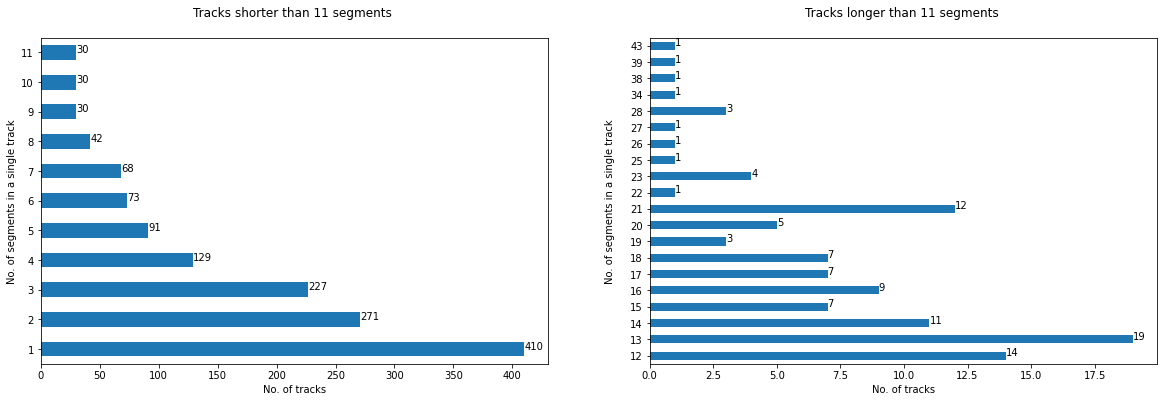


 The number of segments of tracks that are shorter or equal to 11 segments is: 1401

 The number of segments of tracks that are longer than 11 segments is: 109


In [30]:
print("\n Bar chart - The frequency of tracks lengthes (number of segments\
 in a single track) in the Training set. \n\n")

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2) 

segments_int_track = training_set.groupby('track_id')['segment_id'].count()
segments_int_track.value_counts(sort=False)[:11].plot(kind='barh', 
                                                      figsize =(20,6),
                                                      ax =ax1 )
ax1.set_title("Tracks shorter than 11 segments \n")
ax1.set_ylabel('No. of segments in a single track')
ax1.set_xlabel('No. of tracks')

for index, value in enumerate(segments_int_track.value_counts(sort=False)[:11]):
  ax1.text(value, index, str(value))

segments_int_track = training_set.groupby('track_id')['segment_id'].count()
segments_int_track.value_counts(sort=False)[11:].plot(kind='barh',
                                                      figsize =(20,6),
                                                      ax =ax2 )
ax2.set_title("Tracks longer than 11 segments \n")
ax2.set_ylabel('No. of segments in a single track', labelpad =15)
ax2.set_xlabel('No. of tracks')

for index, value in enumerate(segments_int_track.value_counts(sort=False)[11:]):
  ax2.text(value, index, str(value))

plt.show()

print(f"\n The number of segments of tracks that are shorter or equal to 11\
 segments is: {segments_int_track.value_counts(sort=False)[:11].sum()}")
print(f"\n The number of segments of tracks that are longer than 11\
 segments is: {segments_int_track.value_counts(sort=False)[11:].sum()}")

* The majority of the track have less than 11 segments.
* The distribution is skewed towards tracks that have few segments

* The different segments in one single track tend to have a high correlation between each othe. This is a feature we don't want to learn because tracks in the test set have only a single segment

In [31]:
def ratio(series):
  """
  Calculates ratios in a given series.

  Arguments:
    series -- {series} -- series to calculate ratios for.

  Returns:
    ratio_results -- {series} -- ratio result for each integer in the
                                 series array.
  """

  ratio_results = series.apply(lambda x: '{0:.1%}'.format(x/sum(series)))
  
  return ratio_results

Training Set


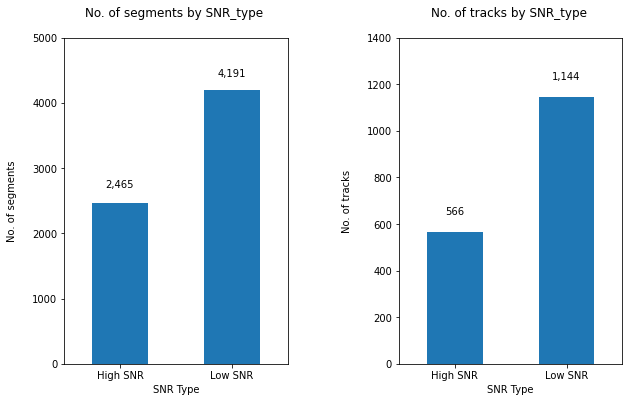

,snr_type,segment_id,ratio
0,HighSNR,2465,37.0%
1,LowSNR,4191,63.0%


,snr_type,track_id,ratio
0,HighSNR,566,33.1%
1,LowSNR,1144,66.9%


In [32]:
# Bar chart - compares the number of tracks and segments by snr type in the training set.

print("Training Set")
fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2) 
fig.subplots_adjust(wspace=0.5)

segments_hsnr_lsnr = training_set.groupby(
    ['snr_type'])['segment_id'].count()
tracks_hsnr_lsnr = training_set.groupby(
    ['snr_type'])['track_id'].nunique()

segments_hsnr_lsnr.plot(kind='bar', figsize=(10,6), ax=ax1)
ax1.set_title("No. of segments by SNR_type \n")
ax1.set_ylabel('No. of segments', labelpad =15)
ax1.set_xlabel('SNR Type')
ax1.set_xticklabels(['High SNR','Low SNR'], rotation =0)
ax1.set_ylim(top=5000)
ax1.text(-0.13,2700,format(segments_hsnr_lsnr[0],','))
ax1.text(0.87,4400,format(segments_hsnr_lsnr[1],','))


tracks_hsnr_lsnr.plot(kind='bar', figsize=(10,6), ax=ax2)
ax2.set_title("No. of tracks by SNR_type \n")
ax2.set_ylabel('No. of tracks', labelpad =15)
ax2.set_xlabel('SNR Type')
ax2.set_xticklabels(['High SNR','Low SNR'], rotation =0)
ax2.set_ylim(top=1400)
ax2.text(-0.09,640,format(tracks_hsnr_lsnr[0],','))
ax2.text(0.87,1220,format(tracks_hsnr_lsnr[1],','))


plt.show()

display(pd.concat([pd.DataFrame(segments_hsnr_lsnr),
                   pd.DataFrame(ratio(segments_hsnr_lsnr)).rename(
                       columns={'segment_id':'ratio'})], 
                   axis=1).reset_index())
display(pd.concat([pd.DataFrame(tracks_hsnr_lsnr),
                   pd.DataFrame(ratio(tracks_hsnr_lsnr)).rename(
                       columns={'track_id':'ratio'})],
                   axis=1).reset_index())

* The dataset is imbalanced. We have 1.7 times more Low SNR segments than High SNR segments. The SNR level is not the target value but it is still important to underline it. 

Public test Set


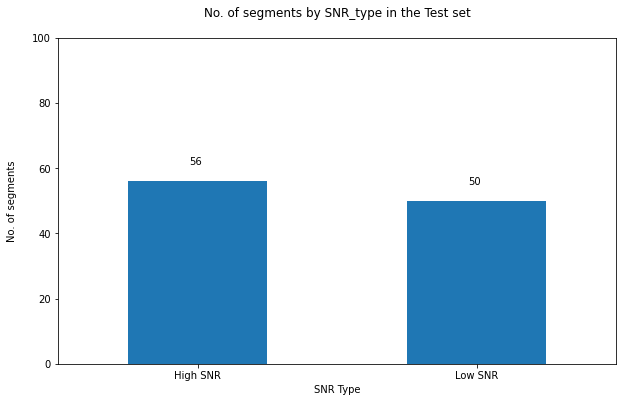

,snr_type,segment_id,ratio
0,HighSNR,56,52.8%
1,LowSNR,50,47.2%


In [33]:
# Bar chart - compares number of segments by snr type in the public test set.
print("Public test Set")
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

segments_hsnr_lsnr_test = test_set.groupby(['snr_type'])['segment_id'].count()
segments_hsnr_lsnr_test.plot(kind='bar', figsize=(10,6), ax=ax1)
ax1.set_title("No. of segments by SNR_type in the Test set\n")
ax1.set_ylabel('No. of segments', labelpad =15)
ax1.set_xlabel('SNR Type')
ax1.set_xticklabels(['High SNR','Low SNR'], rotation =0)
ax1.set_ylim(top=100)

for index, value in enumerate(segments_hsnr_lsnr_test): 
  label = format(value, ',') 
  ax1.annotate(label, xy=(index-0.03 , value+5), color='black')
    
plt.show()

display(pd.concat([pd.DataFrame(segments_hsnr_lsnr_test),pd.DataFrame(
  ratio(segments_hsnr_lsnr_test)).rename(
      columns={'segment_id':'ratio'})],axis=1).reset_index())

The ratio between HighSNR and LowSNR in the test set is more balanced than the ratio in the training set.

####**Other Training Set Fields Descriptive Statistics**

Tracks and Segments frequencies by target_type and snr_type.

Training Set


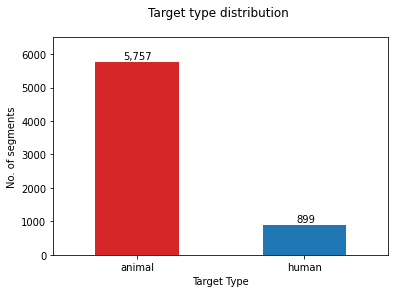

In [34]:
print("Training Set")
target_segments = training_set.groupby(['target_type'])['segment_id'].count()
target_segments_hsnr_lsnr = training_set.groupby(
    ['target_type','snr_type'])['segment_id'].count()
target_tracks_hsnr_lsnr = training_set.groupby(
    ['target_type','snr_type'])['track_id'].nunique()
target_segments.plot(kind='bar', color=['tab:red','tab:blue'])

plt.title('Target type distribution \n')
plt.ylim(top=6500)
plt.ylabel('No. of segments')
plt.xlabel('Target Type')
plt.xticks(rotation =0)
plt.text(-0.08,5850,format(target_segments[0],','))
plt.text(0.95,970,format(target_segments[1],','))
plt.show()

* Regarding the target value. The dataset is imbalanced. 6.4 more animals segments than human ones.

Training Set


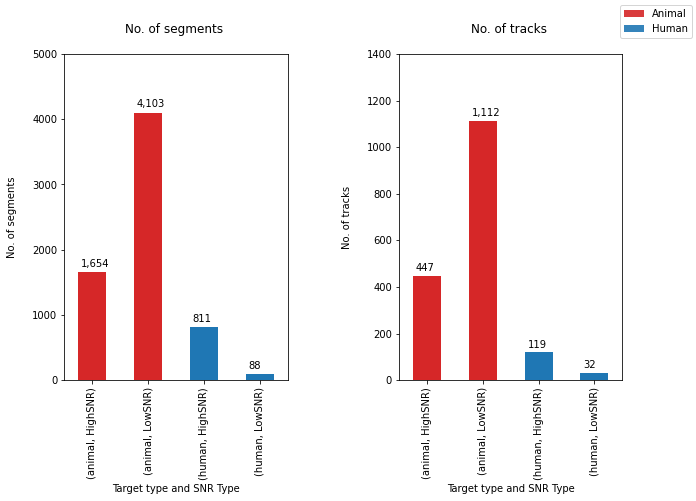

In [35]:
# Bar chart - compares number of segments and tracks by snr type
# and target type in the training set.
print("Training Set")

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2) 
fig.subplots_adjust(wspace=0.5)

target_segments_hsnr_lsnr.plot(kind='bar', figsize=(10,6), 
                               color=[
                                      'tab:red','tab:red',
                                      'tab:blue','tab:blue'
                                      ],
                               label='_nolegend_',ax=ax1)
ax1.set_title("No. of segments \n")
ax1.set_ylabel('No. of segments', labelpad =15)
ax1.set_xlabel('Target type and SNR Type')
ax1.set_ylim(top=5000)
ax1.bar(0, target_segments_hsnr_lsnr[0], width=0.01, alpha=0.9, 
        color='tab:red', label='Animal')
ax1.bar(2, target_segments_hsnr_lsnr[2], width=0.01, alpha=0.9,
        color='tab:blue', label='Human')

for index, value in enumerate(target_segments_hsnr_lsnr): 
  label = format(value, ',') 
  ax1.annotate(label, xy=(index-0.2 , value+80), color='black')

target_tracks_hsnr_lsnr.plot(kind='bar', figsize=(10,6), 
                             color=['tab:red','tab:red',
                                    'tab:blue','tab:blue'
                                    ],
                             label='_nolegend_', ax=ax2)
ax2.set_title("No. of tracks \n")
ax2.set_ylabel('No. of tracks', labelpad =15)
ax2.set_xlabel('Target type and SNR Type')
ax2.set_ylim(top=1400)

for index, value in enumerate(target_tracks_hsnr_lsnr): 
  label = format(value, ',') 
  ax2.annotate(label, xy=(index-0.2 , value+20), color='black')

fig.legend()
plt.show()

In [36]:
target_segments_hsnr_lsnr
segments_display = pd.DataFrame(ratio(target_segments_hsnr_lsnr).reset_index())
segments_display.columns=['targe_type', 'snr_type', 'tracks_count_ratio']
segments_display

,targe_type,snr_type,tracks_count_ratio
0,animal,HighSNR,24.8%
1,animal,LowSNR,61.6%
2,human,HighSNR,12.2%
3,human,LowSNR,1.3%


* The human segments are repreented in majority High SNR, whereas the animal ones are represented in majority low SNR.  
* Let's dive deeper into that

##### **Crosstabulation on the Segments Frequncy - A Deeper Look**
The tables below are crosstabulation of segments frquency by snr_type and target_type.   
The Frequency can be presented in different ratios, depending on the perspective.   
Counting segments relative to the target type or the SNR type.   

For example:    
There are 5,757 animal segments and 899 humans segments in the training set.   
14% of the segments are Humans and 86% are animals.   
37% of the segments are High SNR and 63% are Low SNR.     
Splitting the target type by SNR type show that most of the Low SNR segments are animals (98%).   
Splitting the SNR type by target type shows that 90% of Humans segments are High SNR and 10% are Low SNR.   

See the tables below for more insights.

In [37]:
# Crosstabulation tables presenting same numbers in different perspectives and ratios
print("Count segments: \n")
display(pd.crosstab(training_set['target_type'],training_set['snr_type'],
                    margins = True).round(2))
print("\n Ratio by target type: \n")
display(pd.crosstab(training_set['target_type'],training_set['snr_type'],
                    normalize=0).round(2))
print("\n Ratio by SNR type: \n")
display(pd.crosstab(training_set['target_type'],training_set['snr_type'],
                    normalize=1).round(2))
print("\n Ratio by SNR type and target type: \n")
display(pd.crosstab(training_set['target_type'],training_set['snr_type'],
                    normalize='all',margins = True).round(2))

Count segments: 



snr_type,HighSNR,LowSNR,All
target_type,,,
animal,1654,4103,5757
human,811,88,899
All,2465,4191,6656



 Ratio by target type: 



snr_type,HighSNR,LowSNR
target_type,,
animal,0.29,0.71
human,0.90,0.10



 Ratio by SNR type: 



snr_type,HighSNR,LowSNR
target_type,,
animal,0.67,0.98
human,0.33,0.02



 Ratio by SNR type and target type: 



snr_type,HighSNR,LowSNR,All
target_type,,,
animal,0.25,0.62,0.86
human,0.12,0.01,0.14
All,0.37,0.63,1.00


# Conclusions about SNR and target variables
* The train dataset is imbalanced on the variables : SNR and target value.
* The test dataset is not imbalanced. (We don't have acced to the target values but we know for the SNR variable)
* __Target__: We have 6.4 times more animals classifications than human ones
* __SNR__: We have 1.7 times more lowSNR data than highSNR ones
* Moreover, we know that High SNR is more related to humans and vice versa, low SNR is more related to animal. we should prevent the model to assume this corelation.
> We will have to work on making the data less imbalanced. Oversampling or undersampling are for now the mai ideas


#### **Geolocations**
The segments in the training and the test sets are gathered from different geolocations.   
One of our goals it to classify well even though   
test segments can be from a new and unfamiliar geolocation_type or geolocation_id.   
In the test set there are segments from new geolocations that are not in the training set.

##### **Perfect Multicollinearity - geolocation_id**
The geolocation field has Multicollinearity with other fields in the training set.   
These relations do not necessarily exist in the auxiliary and test sets.   


1. Each geolocation id belongs to one geolocation type (This     
statement holds for all data sets). In each geolocation type can be   
one or more geolocation id.
2. In the training set, each geolocation id has one sensor.
3. In the training set, some of the date indices are unique for     specific geolocations.   
This means that in some calendar days only one geolocation recorded signals.   
4. Some of the geolocations may have only one target type.   
5. All geolocations have High and Low SNR segments.

*Statements 2 and 3 are not necessarily true for geolocations in the auxiliary and test sets.*

In [38]:
print('Geolocation id, geolocation type and sensor_id: \n')
display = pd.DataFrame(training_set.groupby(
    ['geolocation_type','geolocation_id', 'sensor_id'])['segment_id'].
    count())
display.columns=['segment_id count']
display.reset_index(inplace=True)
display

Geolocation id, geolocation type and sensor_id: 



,geolocation_type,geolocation_id,sensor_id,segment_id count
0,A,2,2,251
1,A,3,3,4560
2,C,1,1,944
3,D,4,4,901


##### **Analysis of the Distribution by target_type and geolocation_id**
*See tables and graphs below for an analysis of the distribution of target type and geolocation id.*

In [39]:
target_geolocation_segments = training_set.groupby(
    ['target_type','geolocation_id'])['segment_id'].count()

target_geolocation_id_1_and_4_hsnr_lsnr = training_set.groupby(
    ['target_type', 'geolocation_id','snr_type'])['segment_id'].count().\
    drop(labels=[('animal', '2'), ('animal', '3')])

target_geolocation_id_1_and_4_tracks_hsnr_lsnr = training_set.groupby(
    ['target_type', 'geolocation_id', 'snr_type'])['track_id'].nunique().\
    drop(labels=[('animal', '2'), ('animal', '3')])


Training Set


segment_id count
target_type geolocation_id                  
animal      1                            468
            2                            251
            3                           4560
            4                            478
human       1                            476
            4                            423

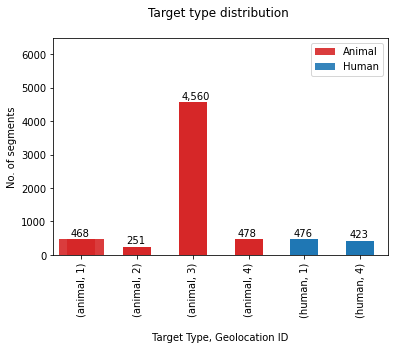

,geolocation_id,snr_type,Animal,Human,Row Total,Animal/Row Total,Human/Row Total
0,1,HighSNR,230,444,674,0.34,0.66
1,1,LowSNR,238,32,270,0.88,0.12
2,2,HighSNR,190,0,190,1.00,0.00
3,2,LowSNR,61,0,61,1.00,0.00
4,3,HighSNR,1043,0,1043,1.00,0.00
5,3,LowSNR,3517,0,3517,1.00,0.00
6,4,HighSNR,191,367,558,0.34,0.66
7,4,LowSNR,287,56,343,0.84,0.16
8,Total,,5757,899,6656,0.86,0.14


In [40]:
print("Training Set")
from IPython.display import display
display(pd.DataFrame(target_geolocation_segments).rename(
    columns={'segment_id':'segment_id count'}))

color_list=['tab:red']*4+['tab:blue']*2
target_geolocation_segments.plot(kind='bar', color = color_list,
                                 label='_nolegend_')
plt.bar(0, target_geolocation_segments[0], alpha=0.9, color='tab:red',
                label='Animal')
plt.bar(6, target_geolocation_segments[4], alpha=0.9, color='tab:blue',
                label='Human')
plt.title('Target type distribution \n')
plt.ylim(top=6500)
plt.ylabel('No. of segments')
plt.xlabel('\n Target Type, Geolocation ID ')

for index, value in enumerate(target_geolocation_segments): 
    label = format(value, ',')
    plt.annotate(label, xy=(index-0.2 , value+90), color='black')
plt.legend()
plt.show()

geolocation_distribution = pd.concat(
    [pd.crosstab([training_set.geolocation_id,training_set.snr_type],
                 training_set.target_type, margins=True, margins_name="Total"),
     pd.crosstab([training_set.geolocation_id,training_set.snr_type], 
                 training_set.target_type, margins=True, normalize=0, 
                 margins_name="Total").round(2)], axis=1
                 )
geolocation_distribution.columns = [
                                    'Animal', 'Human', 'Row Total',
                                    'Animal/Row Total','Human/Row Total'
                                    ]
geolocation_distribution.reset_index(inplace=True)
geolocation_distribution

The same distribution can be presented from a different angle:

In [41]:
geolocation_distribution = pd.concat(
    [pd.crosstab([training_set.target_type, training_set.snr_type],
    training_set.geolocation_id, margins=True, margins_name="Total"), 
    pd.crosstab([training_set.target_type, training_set.snr_type], 
                training_set.geolocation_id, margins=True, normalize=0,
                margins_name="Total").round(2)], axis=1
                )
geolocation_distribution.columns = [
                                    '1', '2', '3', '4', 'Row_Total',
                                    'Ratio 1', 'Ratio 2', 'Ratio 3',
                                    'Ratio 4',
                                    ]
geolocation_distribution

1    2     3    4  ...  Ratio 1  Ratio 2  Ratio 3  Ratio 4
target_type snr_type                       ...                                    
animal      HighSNR   230  190  1043  191  ...     0.14     0.11     0.63     0.12
            LowSNR    238   61  3517  287  ...     0.06     0.01     0.86     0.07
human       HighSNR   444    0     0  367  ...     0.55     0.00     0.00     0.45
            LowSNR     32    0     0   56  ...     0.36     0.00     0.00     0.64
Total                 944  251  4560  901  ...     0.14     0.04     0.69     0.14

[5 rows x 9 columns]

##### **Analysis without geolocation_id 2 and 3**
One can see that geolocation 3 is very different from other geolocations and cause for imbalance in the training set.   
Also, notice that geolocations 2 and 3 have only Animals segments.   
Below, a plot of the same bar chart without geolocations 2 and 3.   

In [42]:
target_geolocation_1_and_4_segments = target_geolocation_segments.drop(
    labels=[('animal', '2'),('animal', '3')])

Training set


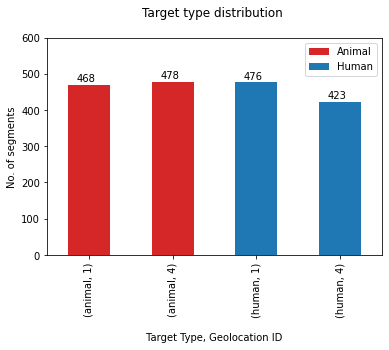

In [43]:
print("Training set")

color_list=['tab:red']*2+['tab:blue']*2
target_geolocation_1_and_4_segments.plot(kind='bar', color = color_list,
                                 label='_nolegend_')
plt.title('Target type distribution \n')
plt.ylim(top=600)
plt.ylabel('No. of segments')
plt.xlabel('\n Target Type, Geolocation ID ')

for index, value in enumerate(target_geolocation_1_and_4_segments):
  label = format(value, ',')
  plt.annotate(label, xy=(index-0.15, value+10), color='black')

plt.bar(0, target_geolocation_1_and_4_segments[0], width=0.01, alpha=1, 
        color='tab:red', label='Animal')
plt.bar(2, target_geolocation_1_and_4_segments[2], width=0.01, alpha=1, 
        color='tab:blue', label='Human')
plt.legend()
plt.show()

Excluding geolocations 2 and 3 reveals a more balanced distribution of the target types.

In [44]:
target_geolocation_segments_count_and_ratio_1_and_4 = pd.DataFrame(data=[target_geolocation_1_and_4_segments,
                                                                 ratio(target_geolocation_1_and_4_segments)])
target_geolocation_segments_count_and_ratio_1_and_4.set_index([['count segments', 'ratio']], inplace=True)
target_geolocation_segments_count_and_ratio_1_and_4

target_type    animal         human       
geolocation_id      1      4      1      4
count segments    468    478    476    423
ratio           25.4%  25.9%  25.8%  22.9%

Training set


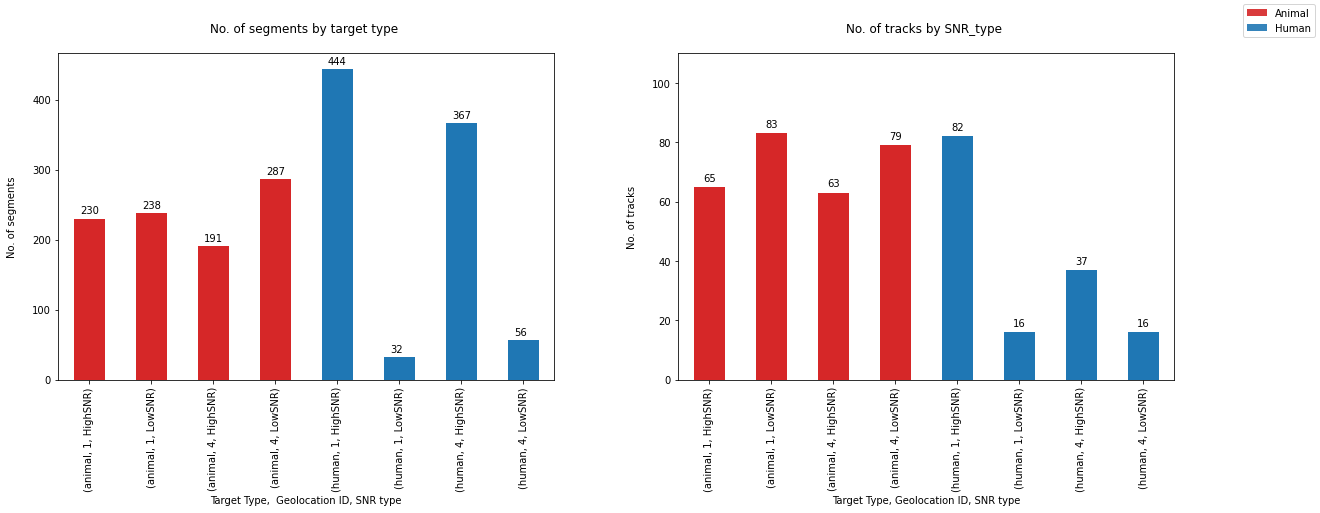

In [45]:
# Bar chart - compares number of segments and tracks by snr type
# target type and geolocation id in the training set.
print("Training set")

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2) 
fig.subplots_adjust(wspace=0.25)
color_list=['tab:red']*4+['tab:blue']*4

target_geolocation_id_1_and_4_hsnr_lsnr.plot(kind='bar', figsize=(20,6), 
                                  color = color_list, label='_nolegend_',
                                  ax=ax1)
ax1.set_title("No. of segments by target type \n")
ax1.set_ylabel('No. of segments', labelpad =15)
ax1.set_xlabel('Target Type,  Geolocation ID, SNR type')
ax1.bar(0, target_geolocation_id_1_and_4_hsnr_lsnr[0], width=0.01, alpha=0.9, 
        color='tab:red', label='Animal')
ax1.bar(2, target_geolocation_id_1_and_4_hsnr_lsnr[6], width=0.01, alpha=0.9,
        color='tab:blue', label='Human')

for index, value in enumerate(target_geolocation_id_1_and_4_hsnr_lsnr):
  label = format(value, ',')
  ax1.annotate(label, xy=(index-0.15, value+7), color='black')


target_geolocation_id_1_and_4_tracks_hsnr_lsnr.plot(kind='bar', figsize=(20,6), 
                                         color=color_list, label='_nolegend_',
                                         ax=ax2)
ax2.set_title("No. of tracks by SNR_type \n")
ax2.set_ylabel('No. of tracks', labelpad =15)
ax2.set_xlabel('Target Type, Geolocation ID, SNR type')

ax2.set_ylim(top=110)
for index, value in enumerate(target_geolocation_id_1_and_4_tracks_hsnr_lsnr):
  label = format(value, ',')
  ax2.annotate(label, xy=(index-0.1, value+2), color='black')

fig.legend()
plt.show()


# Conclusions about geolocations
* Geolocations 2 and 3 detected animals only.
* Geolocation 3 detected a lot of animals and is basically the geolocation that causes the fact that the trainng set is imbalanced on the target value
* Geolocation 1 and 4 are well balanced.
* In the test set, we don't now the geolocations the radars

### **Auxiliary**
The auxiliary dataset is separated into 3 sets:   

1. **Synthetic**   
File name: *MAFAT RADAR Challenge - Auxiliary Synthetic Set V1*      
This set is an augmentation of the High SNR segments from the training set and the auxiliary experiment set. The High SNR segments transformed into Low SNR by adding random "white noise" to each segment. Therefore, the distribution of this set is identical to the distribution of the High SNR segments in the training set. 
     
2. **Background (empty) Tracks**   
File name: *MAFAT RADAR Challenge - Auxiliary Background(empty) Set V1*   
The segments in this set are signals in the same geolocation, time and direction that did not recieve the target.   
The target (human or animal) does not appear in these segments.   
These tracks can help to separate between the "background noise" and the target. Background segments are available only in geolocation_ids 2,3,5,6. 
    
3. **Experiment geolocations (geolocation_id 5,6,7)**   
File name: *MAFAT RADAR Challenge - Auxiliary Experiment Set V1*     
This set has segments of humans from 3 different geolocations.   
The signals from these geolocations are not "natural" recordings (as opposed to the segments in the training and test set) of humans.   
These geolocations are used for controlled tests of the radars.      

#### **Auxiliary - Summary Descriptive Statistics**


*   The Auxiliary Synthetic set has segments from all geolocation_id. There are 50,883 segments from 3,249 tracks.    
These equal to the number of segments and tracks of High SNR in the Training and Experiment data sets.   
The snr_type value is labeled "SynthSNR".
*   The Auxiliary Background set has segments from 4 geolocation_id ([2, 3] - only animals, [5, 6] - only humans). There are 31,128 segments from 3,064 tracks.   
The target_type is labeled "empty".
*   The Auxiliary Experiment set has segments from 3 geolocation_id (5, 6, 7), all segments of the same target ("human"). There are 49,071 segments from 3,006 tracks. 

In [47]:
synthetic_path = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
background_path = 'MAFAT RADAR Challenge - Auxiliary Background(empty) Set V2'
experiment_path = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'

synthetic_set = load_csv_metadata(synthetic_path)
background_set = load_csv_metadata(background_path)
experiment_set = load_csv_metadata(experiment_path)

In [48]:
print(f"The Synthetic set shape is: {synthetic_set.shape}")
print(f"The Background set shape is: {background_set.shape}")
print(f"The Experiment geolocations set shape is: {experiment_set.shape}")


The Synthetic set shape is: (50883, 8)
The Background set shape is: (31128, 8)
The Experiment geolocations set shape is: (49071, 8)


In [49]:
for df in [synthetic_set, background_set, experiment_set]:
  tracks_hsnr_and_lsnr = sum(df[['track_id', 'snr_type']].
                            groupby('track_id', as_index=False)
                            ['snr_type'].nunique()==2)

  tracks_one_snr = sum(df[['track_id', 'snr_type']].
                      groupby('track_id', as_index=False)
                      ['snr_type'].nunique()==1)

  total_count_of_tracks = df.groupby(['track_id', 'snr_type'], 
                                              as_index=False).count()['track_id'].count()
  
  df.name =[x for x in globals() if globals()[x] is df][0]
  print(f'Tracks count in {df.name}')
  print(f'Number of tracks that are High SNR and Low SNR: {tracks_hsnr_and_lsnr:,}')
  print(f'Number of tracks that are High SNR or Low SNR: {tracks_one_snr:,}')
  print(f'Number of total counted tracks (grouped by snr_type and track_id): {total_count_of_tracks:,} \n')

Tracks count in synthetic_set
Number of tracks that are High SNR and Low SNR: 0
Number of tracks that are High SNR or Low SNR: 3,249
Number of total counted tracks (grouped by snr_type and track_id): 3,249 

Tracks count in background_set
Number of tracks that are High SNR and Low SNR: 257
Number of tracks that are High SNR or Low SNR: 2,580
Number of total counted tracks (grouped by snr_type and track_id): 3,094 

Tracks count in experiment_set
Number of tracks that are High SNR and Low SNR: 288
Number of tracks that are High SNR or Low SNR: 2,430
Number of total counted tracks (grouped by snr_type and track_id): 3,006 



#### **Relation between Auxiliary and Training data sets**
Connecting between the segments in the Synthetic and Background data sets to the training set "original" segments   
can be done by using the segment_id.   
The background's segments have segment_id with 1,000,000 added to the original segment_id in the   
training set or the auxiliary experiment set, and the synthetic's segments have segment_id   
with 2,000,000 added to the original segment_id in the training set or the auxiliary experiment set.    
For example:   
segment_id in the training set/auxiliary experiment set of an High SNR segment = 123   
segment_id of the background segment = 1,000,123   
segment_id of the synthetic segment = 2,000,123  


# Spectogram generator

In [50]:
import pickle
from matplotlib.colors import LinearSegmentedColormap

### Load data

In [51]:
def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
  file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
  Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}

  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary

### Processing functions

the functions below are taken from the `plotting spectogram` file. there is a slight change between the way it is processed to plot to the process that happens in the base line.

**calculate spectogram** - in the baseline they used `normalization` and `max_value_on_doppler`. in this implementation there is trasformation that makes sure the minimum value of the spectogram is the median. we should still investigate more why it was processed in this way in the given baseline

In [52]:
def hann(iq, window=None):
  """
  Hann smoothing of 'iq_sweep_burst'.

  Arguments:
    iq -- {ndarray} -- 'iq_sweep_burst' array
    window -- Range of Hann window indices (Default=None)
      If None the whole column is taken

  Returns:
      Regularized iq shaped as (window[1] - window[0] - 2, iq.shape[1])
  """
  if window is None:
      window = [0, len(iq)]

  N = window[1] - window[0] - 1
  n = np.arange(window[0], window[1])
  n = n.reshape(len(n), 1)
  hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
  return (hannCol * iq[window[0]:window[1]])[1:-1]

# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


In [53]:
def calculate_spectrogram(iq_burst, axis=0, flip=True):
  """
  Calculates spectrogram of 'iq_sweep_burst'.

  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform DFT in (Default = 0)
  
  Returns:
    Transformed iq_burst array
  """
  iq = fft(iq_burst)
  iq = np.maximum(np.median(iq) - 1, iq)
  if flip:
    iq = np.flip(iq, axis=0)

  return iq

### Functions to plot the spectogram

In [54]:
def plot_spectrogram(iq_burst, doppler_burst, color_map_name='parula',
                    color_map_path=None, save_path=None, flip=True, return_spec=False):
  """
  Plots spectrogram of 'iq_sweep_burst'.

  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving

  Returns:
    Spectrogram data if return_spec is True
  """
  if color_map_path is not None:
      cm_data = np.load(color_map_path)
      color_map = LinearSegmentedColormap.from_list(color_map_name, cm_data)
  elif color_map_name == 'parula':
      print("Error: when 'parula' color map is used, color_map_path should be provided.")
      print("Switching color map to 'viridis'.")
      color_map = None
  else:
      color_map = plt.get_cmap(color_map_name)

  iq = calculate_spectrogram(iq_burst, flip=flip)
  
  if return_spec:
      return iq

  if doppler_burst is not None:
      pixel_shift = 0.5
      if flip:
          plt.plot(pixel_shift + np.arange(len(doppler_burst)),
                    pixel_shift + (len(iq) - doppler_burst), '.w')
      else:
          plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + doppler_burst, '.w')

  plt.imshow(iq, cmap=color_map)
  plt.show()
  if save_path is not None:
      plt.imsave(save_path, iq, cmap=color_map)

  plt.clf()


def get_track_id(data, segment_id):
  """
  Get track id from segment id.

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- segment id of a track

  Returns:
    Track id
  """
  segment_index = np.where(data['segment_id'] == segment_id)
  return data['track_id'][segment_index][0]


def has_single_snr_type(data, id, is_segment):
  """
  Check if a track has a single SNR type or both High and Low SNR.

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    id -- {int} -- segment or track id, based on is_segment
    is_segment -- {bool} -- If true then id is segment, otherwise id is track

  Returns:
    True if track has a High or Low SNR but not both
  """
  if is_segment:
    id = get_track_id(data, id)
  return np.all(data['snr_type'][np.where(data['track_id'] == id)] == data['snr_type']\
                [np.where(data['track_id'] == id)][0], axis = 0)

In [55]:
#@title
spectrogram_cmap = np.array([[2.422e-01, 1.504e-01, 6.603e-01],
       [2.444e-01, 1.534e-01, 6.728e-01],
       [2.464e-01, 1.569e-01, 6.847e-01],
       [2.484e-01, 1.607e-01, 6.961e-01],
       [2.503e-01, 1.648e-01, 7.071e-01],
       [2.522e-01, 1.689e-01, 7.179e-01],
       [2.540e-01, 1.732e-01, 7.286e-01],
       [2.558e-01, 1.773e-01, 7.393e-01],
       [2.576e-01, 1.814e-01, 7.501e-01],
       [2.594e-01, 1.854e-01, 7.610e-01],
       [2.611e-01, 1.893e-01, 7.719e-01],
       [2.628e-01, 1.932e-01, 7.828e-01],
       [2.645e-01, 1.972e-01, 7.937e-01],
       [2.661e-01, 2.011e-01, 8.043e-01],
       [2.676e-01, 2.052e-01, 8.148e-01],
       [2.691e-01, 2.094e-01, 8.249e-01],
       [2.704e-01, 2.138e-01, 8.346e-01],
       [2.717e-01, 2.184e-01, 8.439e-01],
       [2.729e-01, 2.231e-01, 8.528e-01],
       [2.740e-01, 2.280e-01, 8.612e-01],
       [2.749e-01, 2.330e-01, 8.692e-01],
       [2.758e-01, 2.382e-01, 8.767e-01],
       [2.766e-01, 2.435e-01, 8.840e-01],
       [2.774e-01, 2.489e-01, 8.908e-01],
       [2.781e-01, 2.543e-01, 8.973e-01],
       [2.788e-01, 2.598e-01, 9.035e-01],
       [2.794e-01, 2.653e-01, 9.094e-01],
       [2.798e-01, 2.708e-01, 9.150e-01],
       [2.802e-01, 2.764e-01, 9.204e-01],
       [2.806e-01, 2.819e-01, 9.255e-01],
       [2.809e-01, 2.875e-01, 9.305e-01],
       [2.811e-01, 2.930e-01, 9.352e-01],
       [2.813e-01, 2.985e-01, 9.397e-01],
       [2.814e-01, 3.040e-01, 9.441e-01],
       [2.814e-01, 3.095e-01, 9.483e-01],
       [2.813e-01, 3.150e-01, 9.524e-01],
       [2.811e-01, 3.204e-01, 9.563e-01],
       [2.809e-01, 3.259e-01, 9.600e-01],
       [2.807e-01, 3.313e-01, 9.636e-01],
       [2.803e-01, 3.367e-01, 9.670e-01],
       [2.798e-01, 3.421e-01, 9.702e-01],
       [2.791e-01, 3.475e-01, 9.733e-01],
       [2.784e-01, 3.529e-01, 9.763e-01],
       [2.776e-01, 3.583e-01, 9.791e-01],
       [2.766e-01, 3.638e-01, 9.817e-01],
       [2.754e-01, 3.693e-01, 9.840e-01],
       [2.741e-01, 3.748e-01, 9.862e-01],
       [2.726e-01, 3.804e-01, 9.881e-01],
       [2.710e-01, 3.860e-01, 9.898e-01],
       [2.691e-01, 3.916e-01, 9.912e-01],
       [2.670e-01, 3.973e-01, 9.924e-01],
       [2.647e-01, 4.030e-01, 9.935e-01],
       [2.621e-01, 4.088e-01, 9.946e-01],
       [2.591e-01, 4.145e-01, 9.955e-01],
       [2.556e-01, 4.203e-01, 9.965e-01],
       [2.517e-01, 4.261e-01, 9.974e-01],
       [2.473e-01, 4.319e-01, 9.983e-01],
       [2.424e-01, 4.378e-01, 9.991e-01],
       [2.369e-01, 4.437e-01, 9.996e-01],
       [2.311e-01, 4.497e-01, 9.995e-01],
       [2.250e-01, 4.559e-01, 9.985e-01],
       [2.189e-01, 4.620e-01, 9.968e-01],
       [2.128e-01, 4.682e-01, 9.948e-01],
       [2.066e-01, 4.743e-01, 9.926e-01],
       [2.006e-01, 4.803e-01, 9.906e-01],
       [1.950e-01, 4.861e-01, 9.887e-01],
       [1.903e-01, 4.919e-01, 9.867e-01],
       [1.869e-01, 4.975e-01, 9.844e-01],
       [1.847e-01, 5.030e-01, 9.819e-01],
       [1.831e-01, 5.084e-01, 9.793e-01],
       [1.818e-01, 5.138e-01, 9.766e-01],
       [1.806e-01, 5.191e-01, 9.738e-01],
       [1.795e-01, 5.244e-01, 9.709e-01],
       [1.785e-01, 5.296e-01, 9.677e-01],
       [1.778e-01, 5.349e-01, 9.641e-01],
       [1.773e-01, 5.401e-01, 9.602e-01],
       [1.768e-01, 5.452e-01, 9.560e-01],
       [1.764e-01, 5.504e-01, 9.516e-01],
       [1.755e-01, 5.554e-01, 9.473e-01],
       [1.740e-01, 5.605e-01, 9.432e-01],
       [1.716e-01, 5.655e-01, 9.393e-01],
       [1.686e-01, 5.705e-01, 9.357e-01],
       [1.649e-01, 5.755e-01, 9.323e-01],
       [1.610e-01, 5.805e-01, 9.289e-01],
       [1.573e-01, 5.854e-01, 9.254e-01],
       [1.540e-01, 5.902e-01, 9.218e-01],
       [1.513e-01, 5.950e-01, 9.182e-01],
       [1.492e-01, 5.997e-01, 9.147e-01],
       [1.475e-01, 6.043e-01, 9.113e-01],
       [1.461e-01, 6.089e-01, 9.080e-01],
       [1.446e-01, 6.135e-01, 9.050e-01],
       [1.429e-01, 6.180e-01, 9.022e-01],
       [1.408e-01, 6.226e-01, 8.998e-01],
       [1.383e-01, 6.272e-01, 8.975e-01],
       [1.354e-01, 6.317e-01, 8.953e-01],
       [1.321e-01, 6.363e-01, 8.932e-01],
       [1.288e-01, 6.408e-01, 8.910e-01],
       [1.253e-01, 6.453e-01, 8.887e-01],
       [1.219e-01, 6.497e-01, 8.862e-01],
       [1.185e-01, 6.541e-01, 8.834e-01],
       [1.152e-01, 6.584e-01, 8.804e-01],
       [1.119e-01, 6.627e-01, 8.770e-01],
       [1.085e-01, 6.669e-01, 8.734e-01],
       [1.048e-01, 6.710e-01, 8.695e-01],
       [1.009e-01, 6.750e-01, 8.653e-01],
       [9.640e-02, 6.789e-01, 8.609e-01],
       [9.140e-02, 6.828e-01, 8.562e-01],
       [8.550e-02, 6.865e-01, 8.513e-01],
       [7.890e-02, 6.902e-01, 8.462e-01],
       [7.130e-02, 6.938e-01, 8.409e-01],
       [6.280e-02, 6.972e-01, 8.355e-01],
       [5.350e-02, 7.006e-01, 8.299e-01],
       [4.330e-02, 7.039e-01, 8.242e-01],
       [3.280e-02, 7.071e-01, 8.183e-01],
       [2.340e-02, 7.103e-01, 8.124e-01],
       [1.550e-02, 7.133e-01, 8.064e-01],
       [9.100e-03, 7.163e-01, 8.003e-01],
       [4.600e-03, 7.192e-01, 7.941e-01],
       [1.900e-03, 7.220e-01, 7.878e-01],
       [9.000e-04, 7.248e-01, 7.815e-01],
       [1.800e-03, 7.275e-01, 7.752e-01],
       [4.600e-03, 7.301e-01, 7.688e-01],
       [9.400e-03, 7.327e-01, 7.623e-01],
       [1.620e-02, 7.352e-01, 7.558e-01],
       [2.530e-02, 7.376e-01, 7.492e-01],
       [3.690e-02, 7.400e-01, 7.426e-01],
       [5.040e-02, 7.423e-01, 7.359e-01],
       [6.380e-02, 7.446e-01, 7.292e-01],
       [7.700e-02, 7.468e-01, 7.224e-01],
       [8.990e-02, 7.489e-01, 7.156e-01],
       [1.023e-01, 7.510e-01, 7.088e-01],
       [1.141e-01, 7.531e-01, 7.019e-01],
       [1.252e-01, 7.552e-01, 6.950e-01],
       [1.354e-01, 7.572e-01, 6.881e-01],
       [1.448e-01, 7.593e-01, 6.812e-01],
       [1.532e-01, 7.614e-01, 6.741e-01],
       [1.609e-01, 7.635e-01, 6.671e-01],
       [1.678e-01, 7.656e-01, 6.599e-01],
       [1.741e-01, 7.678e-01, 6.527e-01],
       [1.799e-01, 7.699e-01, 6.454e-01],
       [1.853e-01, 7.721e-01, 6.379e-01],
       [1.905e-01, 7.743e-01, 6.303e-01],
       [1.954e-01, 7.765e-01, 6.225e-01],
       [2.003e-01, 7.787e-01, 6.146e-01],
       [2.061e-01, 7.808e-01, 6.065e-01],
       [2.118e-01, 7.828e-01, 5.983e-01],
       [2.178e-01, 7.849e-01, 5.899e-01],
       [2.244e-01, 7.869e-01, 5.813e-01],
       [2.318e-01, 7.887e-01, 5.725e-01],
       [2.401e-01, 7.905e-01, 5.636e-01],
       [2.491e-01, 7.922e-01, 5.546e-01],
       [2.589e-01, 7.937e-01, 5.454e-01],
       [2.695e-01, 7.951e-01, 5.360e-01],
       [2.809e-01, 7.964e-01, 5.266e-01],
       [2.929e-01, 7.975e-01, 5.170e-01],
       [3.052e-01, 7.985e-01, 5.074e-01],
       [3.176e-01, 7.994e-01, 4.975e-01],
       [3.301e-01, 8.002e-01, 4.876e-01],
       [3.424e-01, 8.009e-01, 4.774e-01],
       [3.548e-01, 8.016e-01, 4.669e-01],
       [3.671e-01, 8.021e-01, 4.563e-01],
       [3.795e-01, 8.026e-01, 4.454e-01],
       [3.921e-01, 8.029e-01, 4.344e-01],
       [4.050e-01, 8.031e-01, 4.233e-01],
       [4.184e-01, 8.030e-01, 4.122e-01],
       [4.322e-01, 8.028e-01, 4.013e-01],
       [4.463e-01, 8.024e-01, 3.904e-01],
       [4.608e-01, 8.018e-01, 3.797e-01],
       [4.753e-01, 8.011e-01, 3.691e-01],
       [4.899e-01, 8.002e-01, 3.586e-01],
       [5.044e-01, 7.993e-01, 3.480e-01],
       [5.187e-01, 7.982e-01, 3.374e-01],
       [5.329e-01, 7.970e-01, 3.267e-01],
       [5.470e-01, 7.957e-01, 3.159e-01],
       [5.609e-01, 7.943e-01, 3.050e-01],
       [5.748e-01, 7.929e-01, 2.941e-01],
       [5.886e-01, 7.913e-01, 2.833e-01],
       [6.024e-01, 7.896e-01, 2.726e-01],
       [6.161e-01, 7.878e-01, 2.622e-01],
       [6.297e-01, 7.859e-01, 2.521e-01],
       [6.433e-01, 7.839e-01, 2.423e-01],
       [6.567e-01, 7.818e-01, 2.329e-01],
       [6.701e-01, 7.796e-01, 2.239e-01],
       [6.833e-01, 7.773e-01, 2.155e-01],
       [6.963e-01, 7.750e-01, 2.075e-01],
       [7.091e-01, 7.727e-01, 1.998e-01],
       [7.218e-01, 7.703e-01, 1.924e-01],
       [7.344e-01, 7.679e-01, 1.852e-01],
       [7.468e-01, 7.654e-01, 1.782e-01],
       [7.590e-01, 7.629e-01, 1.717e-01],
       [7.710e-01, 7.604e-01, 1.658e-01],
       [7.829e-01, 7.579e-01, 1.608e-01],
       [7.945e-01, 7.554e-01, 1.570e-01],
       [8.060e-01, 7.529e-01, 1.546e-01],
       [8.172e-01, 7.505e-01, 1.535e-01],
       [8.281e-01, 7.481e-01, 1.536e-01],
       [8.389e-01, 7.457e-01, 1.546e-01],
       [8.495e-01, 7.435e-01, 1.564e-01],
       [8.600e-01, 7.413e-01, 1.587e-01],
       [8.703e-01, 7.392e-01, 1.615e-01],
       [8.804e-01, 7.372e-01, 1.650e-01],
       [8.903e-01, 7.353e-01, 1.695e-01],
       [9.000e-01, 7.336e-01, 1.749e-01],
       [9.093e-01, 7.321e-01, 1.815e-01],
       [9.184e-01, 7.308e-01, 1.890e-01],
       [9.272e-01, 7.298e-01, 1.973e-01],
       [9.357e-01, 7.290e-01, 2.061e-01],
       [9.440e-01, 7.285e-01, 2.151e-01],
       [9.523e-01, 7.284e-01, 2.237e-01],
       [9.606e-01, 7.285e-01, 2.312e-01],
       [9.689e-01, 7.292e-01, 2.373e-01],
       [9.770e-01, 7.304e-01, 2.418e-01],
       [9.842e-01, 7.330e-01, 2.446e-01],
       [9.900e-01, 7.365e-01, 2.429e-01],
       [9.946e-01, 7.407e-01, 2.394e-01],
       [9.966e-01, 7.458e-01, 2.351e-01],
       [9.971e-01, 7.513e-01, 2.309e-01],
       [9.972e-01, 7.569e-01, 2.267e-01],
       [9.971e-01, 7.626e-01, 2.224e-01],
       [9.969e-01, 7.683e-01, 2.181e-01],
       [9.966e-01, 7.740e-01, 2.138e-01],
       [9.962e-01, 7.798e-01, 2.095e-01],
       [9.957e-01, 7.856e-01, 2.053e-01],
       [9.949e-01, 7.915e-01, 2.012e-01],
       [9.938e-01, 7.974e-01, 1.974e-01],
       [9.923e-01, 8.034e-01, 1.939e-01],
       [9.906e-01, 8.095e-01, 1.906e-01],
       [9.885e-01, 8.156e-01, 1.875e-01],
       [9.861e-01, 8.218e-01, 1.846e-01],
       [9.835e-01, 8.280e-01, 1.817e-01],
       [9.807e-01, 8.342e-01, 1.787e-01],
       [9.778e-01, 8.404e-01, 1.757e-01],
       [9.748e-01, 8.467e-01, 1.726e-01],
       [9.720e-01, 8.529e-01, 1.695e-01],
       [9.694e-01, 8.591e-01, 1.665e-01],
       [9.671e-01, 8.654e-01, 1.636e-01],
       [9.651e-01, 8.716e-01, 1.608e-01],
       [9.634e-01, 8.778e-01, 1.582e-01],
       [9.619e-01, 8.840e-01, 1.557e-01],
       [9.608e-01, 8.902e-01, 1.532e-01],
       [9.601e-01, 8.963e-01, 1.507e-01],
       [9.596e-01, 9.023e-01, 1.480e-01],
       [9.595e-01, 9.084e-01, 1.450e-01],
       [9.597e-01, 9.143e-01, 1.418e-01],
       [9.601e-01, 9.203e-01, 1.382e-01],
       [9.608e-01, 9.262e-01, 1.344e-01],
       [9.618e-01, 9.320e-01, 1.304e-01],
       [9.629e-01, 9.379e-01, 1.261e-01],
       [9.642e-01, 9.437e-01, 1.216e-01],
       [9.657e-01, 9.494e-01, 1.168e-01],
       [9.674e-01, 9.552e-01, 1.116e-01],
       [9.692e-01, 9.609e-01, 1.061e-01],
       [9.711e-01, 9.667e-01, 1.001e-01],
       [9.730e-01, 9.724e-01, 9.380e-02],
       [9.749e-01, 9.782e-01, 8.720e-02],
       [9.769e-01, 9.839e-01, 8.050e-02]])

np.save('/content/cmap.npy', spectrogram_cmap)

In [56]:
def spectrogram(data, segment_id=None, plot_track=False, track_id=None, snr_plot='both',
                color_map_name='parula', color_map_path=None, save_path=None, flip=True,
                return_spec=False):
  """
  Plots spectrogram of a track or of a single segment I/Q matrix ('iq_sweep_burst').
  If segment_id is passed than plots spectrogram for the specific segment,
  unless plot_track=='True' and than plots the entire track of the segment.
  If track_id is passed than plots spectrogram for the entire track.
  In case that the Track has two SNR Types asks the user to choose HighSNR or LowSNR or ignore.
  If color map is 'parula' must pass color_map_path.        

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- the segment_id number of the wanted segment
    track_id -- {int} -- the segment_id number of the wanted segment
    snr_plot -- {str} -- If track has both high and low SNR signals which SNR to plot (Default = 'both')
      The valid values are: 'HighSNR', 'LowSNR' or 'both'
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving
  
  Returns:
    Spectrogram data if return_spec is True
  """
  if (segment_id == None) and (track_id == None):
    raise ValueError("You must pass segment id or track id")
  elif (segment_id != None) and (track_id != None):
    raise ValueError("You must pass segment id or track id, you can't pass both.",
    "\nIf you want to plot the entire track of a segment by passig only the segment_id than set 'plot_track'=True")
  elif (segment_id != None) and (track_id == None):
    segment_index = np.where(data['segment_id'] == segment_id)
    if not plot_track:
      iq_matrix = data['iq_sweep_burst'][segment_index]
      iq_matrix = iq_matrix.reshape(iq_matrix.shape[1], -1)
      doppler_vector = data['doppler_burst'][segment_index]
      doppler_vector = doppler_vector.reshape(doppler_vector.shape[1])
      return doppler_vector, plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, color_map_name=color_map_name,
                      color_map_path=color_map_path, save_path=save_path, flip=flip, return_spec=return_spec)
    else:
        '''plot_track=True than plots all track by segment_id'''
        track_id = data['track_id'][segment_index]
        return spectrogram(data, segment_id=None, plot_track=False, track_id=track_id,
                    snr_plot=snr_plot, color_map_name=color_map_name, 
                    color_map_path=color_map_path, save_path=save_path, flip=flip, 
                    return_spec=return_spec)
  else:
    ''' track_id is passed, plotting the entire track '''
    track_indices = np.where(data['track_id'] == track_id)
    iq_list = []
    dopller_list = []

    if (snr_plot != 'both') and (not has_single_snr_type(data, track_id, False)):
      # if we want only single snr plot, but this specific track have several, picl the chosen one
      track_indices = np.where((data['track_id'] == track_id) & (data['snr_type'] == snr_plot))
    
    for i in track_indices:
        iq_list.append(data['iq_sweep_burst'][i])
        dopller_list.append(data['doppler_burst'][i])
      
    iq_matrix = np.concatenate(np.concatenate(iq_list, axis=1),axis=1)
    doppler_vector = np.concatenate(np.concatenate(dopller_list, axis=0),axis=0)

    return doppler_vector, plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, 
                     color_map_name=color_map_name, color_map_path=color_map_path, 
                     save_path=save_path, flip=flip, return_spec=return_spec)

In [57]:
# Load data
training_path = 'MAFAT RADAR Challenge - Training Set V1'
training = load_data(training_path)

### Segment data study

In [58]:
segments = training['iq_sweep_burst']
print(f"In the training set we got {segments.shape[0]} segments.")
print(f"Each of them representing an IQ matrix of size {segments.shape[1]} * {segments.shape[2]}")

In the training set we got 6656 segments.
Each of them representing an IQ matrix of size 128 * 32


In [59]:
segment = segments[0]
print(f"Exemple of the value in one of the cell of the matrix, cell (0, 0) : {segment[0][0]} ")
print(f"Type of the value : {type(segment[0][0])} ")

Exemple of the value in one of the cell of the matrix, cell (0, 0) : (6900.381244659424+6699.4177532196045j) 
Type of the value : <class 'numpy.complex128'> 


### Plot basic spectogram

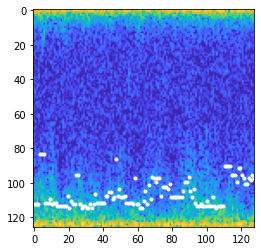

<Figure size 432x288 with 0 Axes>

In [60]:
spectrogram(training, track_id=11, color_map_path='/content/cmap.npy');

### Function for presenting animal and human side by side

In [61]:
def plot_animal_versus_human(data, num_examples=3, return_spec=True, color_map_path='/content/cmap.npy'):

    pixel_shift = 0.5
    cm_data = np.load(color_map_path)
    color_map = LinearSegmentedColormap.from_list('parula', cm_data)


    animals_list = list(set(data["track_id"][np.where(data['target_type'] == 'animal')]))
    humans_list = list(set(data["track_id"][np.where(data['target_type'] == 'human')]))

    if (not animals_list) or (not humans_list):
        animals_list = list(set(data["track_id"][np.where(data['target_type'] == 0)]))
        humans_list = list(set(data["track_id"][np.where(data['target_type'] == 1)]))

    animals = np.random.choice(animals_list, size=num_examples)
    humans = np.random.choice(humans_list, size=num_examples)

    fig, ax = plt.subplots(num_examples, 2, figsize=(15, 3*num_examples))

    for i in range(num_examples):
      doppler_burst_animal, iq_animal = spectrogram(data, track_id=animals[i], return_spec=return_spec, color_map_path=color_map_path)
      doppler_burst_human, iq_human = spectrogram(data, track_id=humans[i], return_spec=return_spec, color_map_path=color_map_path)

      ax[i][0].plot(pixel_shift + np.arange(len(doppler_burst_animal)), pixel_shift + (len(iq_animal) - doppler_burst_animal), '.w')
      ax[i][1].plot(pixel_shift + np.arange(len(doppler_burst_human)), pixel_shift + (len(iq_human) - doppler_burst_human), '.w')

      ax[i][0].imshow(iq_animal, cmap=color_map);
      ax[i][1].imshow(iq_human, cmap=color_map);

      ax[i][0].set_title(f"animal - track id: {animals[i]}")
      ax[i][1].set_title(f"human - track id: {humans[i]}")
    
    plt.tight_layout()
  

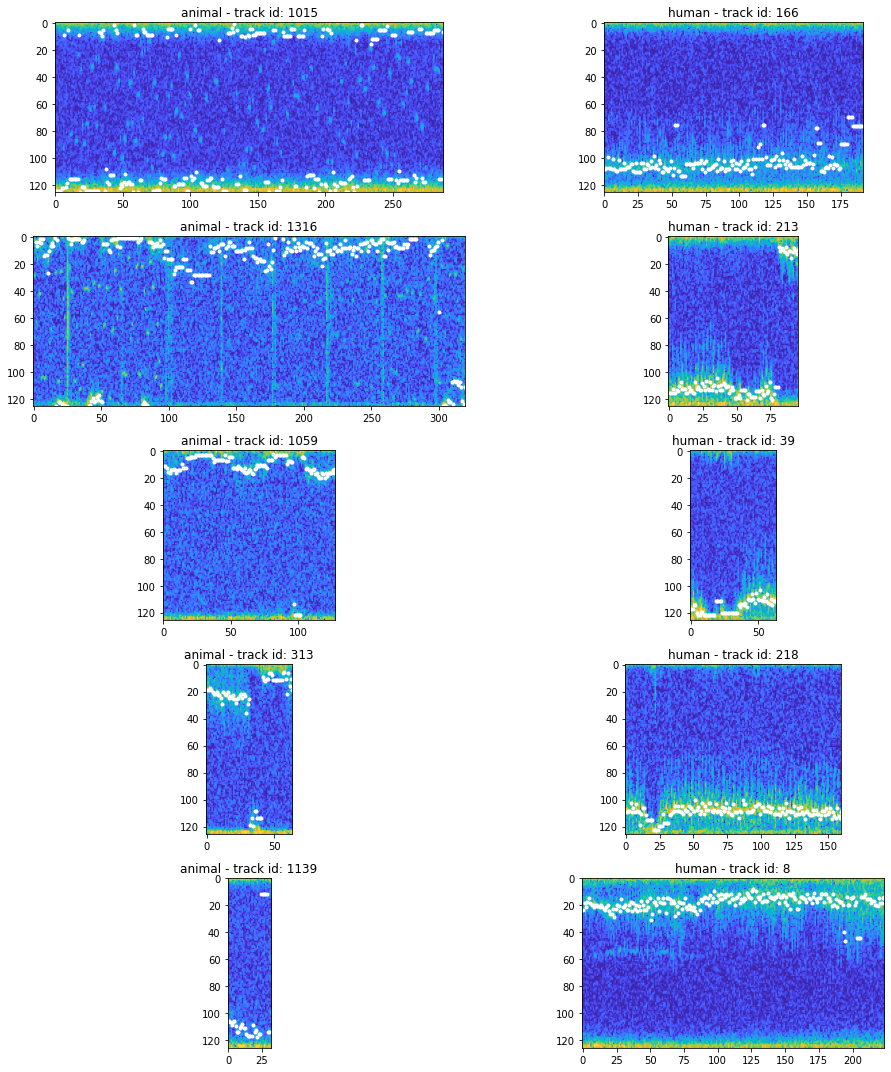

In [62]:
plot_animal_versus_human(training, num_examples=5)

### Ploting difference between SNR type

In [63]:
def plot_snr_difference(data, num_examples=3, return_spec=True, color_map_path='/content/cmap.npy'):

    pixel_shift = 0.5
    cm_data = np.load(color_map_path)
    color_map = LinearSegmentedColormap.from_list('parula', cm_data)


    animals_list = list(set(data["track_id"][np.where(data['target_type'] == 'animal')]))
    humans_list = list(set(data["track_id"][np.where(data['target_type'] == 'human')]))

    if (not animals_list) or (not humans_list):
        animals_list = list(set(data["track_id"][np.where(data['target_type'] == 0)]))
        humans_list = list(set(data["track_id"][np.where(data['target_type'] == 1)]))

    both_snr_track_animal = [track for track in animals_list if not has_single_snr_type(data, track, is_segment=False)]
    both_snr_track_human = [track for track in humans_list if not has_single_snr_type(data, track, is_segment=False)]


    animals = np.random.choice(both_snr_track_animal, size=num_examples)
    humans = np.random.choice(both_snr_track_human, size=num_examples)

    fig, ax = plt.subplots(num_examples, 3, figsize=(15, 3*num_examples))

    for i in range(num_examples):
      doppler_burst_animal_high, iq_animal_high = spectrogram(data, track_id=animals[i], return_spec=return_spec,snr_plot='HighSNR', color_map_path=color_map_path)
      ax[i][0].plot(pixel_shift + np.arange(len(doppler_burst_animal_high)), pixel_shift + (len(iq_animal_high) - doppler_burst_animal_high), '.w')
      ax[i][0].imshow(iq_animal_high, cmap=color_map);
      ax[i][0].set_title(f"animal - track id: {animals[i]}, High SNR")

      doppler_burst_animal_low, iq_animal_low = spectrogram(data, track_id=animals[i], return_spec=return_spec,snr_plot='LowSNR', color_map_path=color_map_path)
      ax[i][1].plot(pixel_shift + np.arange(len(doppler_burst_animal_low)), pixel_shift + (len(iq_animal_low) - doppler_burst_animal_low), '.w')
      ax[i][1].imshow(iq_animal_low, cmap=color_map);
      ax[i][1].set_title(f"animal - track id: {animals[i]}, Low SNR")

      doppler_burst_animal_both, iq_animal_both = spectrogram(data, track_id=animals[i], return_spec=return_spec,snr_plot='both', color_map_path=color_map_path)
      ax[i][2].plot(pixel_shift + np.arange(len(doppler_burst_animal_both)), pixel_shift + (len(iq_animal_both) - doppler_burst_animal_both), '.w')
      ax[i][2].imshow(iq_animal_both, cmap=color_map);
      ax[i][2].set_title(f"animal - track id: {animals[i]}, both")


    plt.tight_layout()    
    


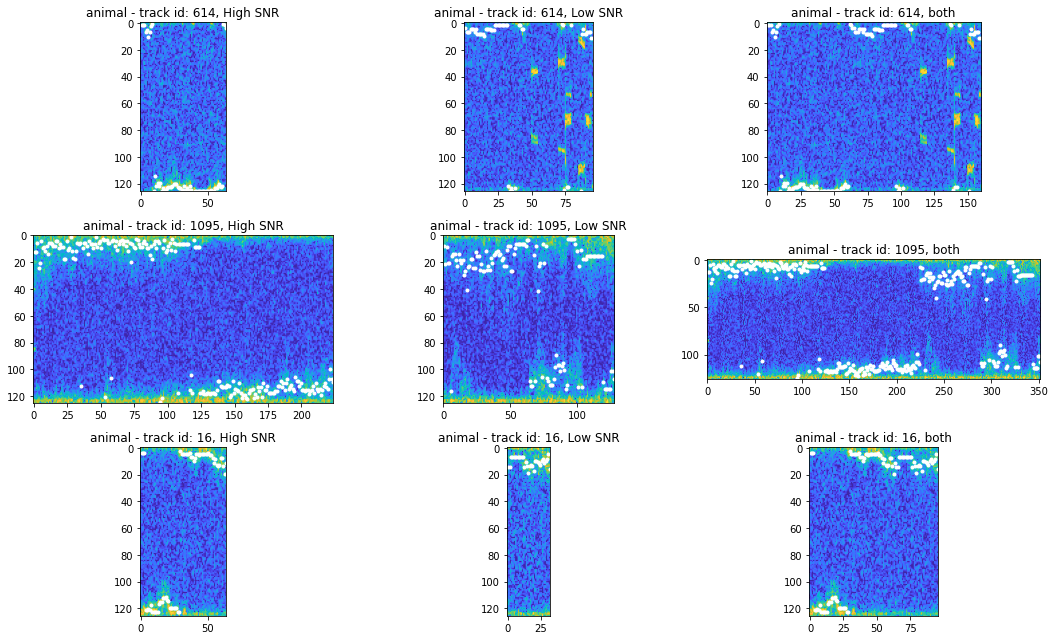

In [64]:
plot_snr_difference(training)

### ploting examples from the auxilary datasets and from the test set

In [65]:
# Loading Auxiliary Experiment set - set has segments of humans not "natural" 
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

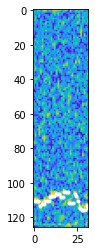

<Figure size 432x288 with 0 Axes>

In [66]:
spectrogram(experiment_auxiliary_df, track_id=275251, color_map_path='/content/cmap.npy');

the spectogram of the expiriment dataset looks like maybe it was already processed or any other possibility. we should investigate this result

In [67]:
# Loading Auxiliary Synthetic set - 
#  High SNR segments transformed into Low SNR by adding random "white noise" to each segment
synthetic_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
synthetic_auxiliary_df = load_data(synthetic_auxiliary)

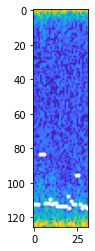

<Figure size 432x288 with 0 Axes>

In [68]:
spectrogram(synthetic_auxiliary_df, track_id=11, color_map_path='/content/cmap.npy');

In [69]:
# Loading Auxiliary Background(empty) set - 
# segments in this set are signals in the same geolocation, time and direction that did not recieve the target
background_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Background(empty) Set V1'
background_auxiliary_df = load_data(background_auxiliary)

FileNotFoundError: ignored

In [ ]:
spectrogram(background_auxiliary_df, track_id=349, color_map_path='/content/cmap.npy');